In [17]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

train = pd.read_csv('train_zero.csv', sep =',', index_col=False)
test = pd.read_csv('test_zero.csv', sep =',', index_col=False)

In [18]:
train = train.drop(['Unnamed: 0'], axis=1)
test = test.drop(['Unnamed: 0'], axis=1)

In [19]:
train = train.drop(['NU_INSCRICAO'], axis = 1)
NU_INSCRICAO = test['NU_INSCRICAO'].values
test = test.drop(['NU_INSCRICAO'], axis = 1)

In [20]:
train.shape, test.shape

((13730, 39), (4576, 38))

Let's get our dummy variables from the columns with discrete features.

In [21]:
train.select_dtypes(['object']).columns
test.select_dtypes(['object']).columns

Index(['TP_SEXO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q047'], dtype='object')

In [22]:
train_dummy = pd.get_dummies(train[train.select_dtypes(['object']).columns])
test_dummy = pd.get_dummies(test[test.select_dtypes(['object']).columns])

In [23]:
train = train.drop(train.select_dtypes(['object']).columns, axis = 1)
test = test.drop(test.select_dtypes(['object']).columns, axis = 1)

In [60]:
train = pd.concat([train, train_dummy], axis = 1)
test = pd.concat([test, test_dummy], axis = 1)
train.shape, test.shape

((13730, 131), (4576, 130))

Now we can split the data in 70%/30%

In [78]:
from sklearn.model_selection import train_test_split

y_col = 'NU_NOTA_MT'

feature_cols = [x for x in train.columns if x != y_col]
x_data = train[feature_cols]
y_data = train[y_col]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.3, random_state = 42)

In [79]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

sc.fit(x_train)

x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

In [87]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [99]:
y_train_predicted = lr.predict(x_train)
y_test_predicted = lr.predict(x_test)

In [100]:
final = pd.DataFrame(list(zip(NU_INSCRICAO, y_test)), columns = ['NU_INSCRICAO', 'NU_NOTA_MT'])
final.to_csv('answer.csv', sep=',')

In [101]:
#final.loc[final[final.NU_NOTA_MT < 30].index, 'NU_NOTA_MT'] = 0
#final.to_csv('answer.csv', sep=',')

In [102]:
final.head(4)

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,425.2
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,0.0
2,b38a03232f43b11c9d0788abaf060f7366053b6d,439.0
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,874.1


We have already fitted our model. Now, let's analyze our predictions against the responses. (lr.score will return R²)

In [103]:
lr.score(x_train, y_train), lr.score(x_test, y_test)

(0.9140328276052718, 0.9201169425016202)

In [111]:
from sklearn.metrics import mean_squared_error
import math

errors = list()

errors.append(pd.Series({'train': mean_squared_error(y_train, y_train_predicted),
                           'test' : mean_squared_error(y_test,  y_test_predicted)},
                           name='errors'))

errors = pd.concat(errors, axis=1)
errors

,errors
train,66.690640
test,65.541801


In [139]:
y_test_list = list(y_test)
y_test_predicted_list = list(y_test_predicted)

pandas.core.series.Series

In order to plot the fitted values versus residuals, we need to calculate the residuals first:

In [137]:
residuals = list()

for x, y in zip(y_test_list, y_test_predicted_list):
    residuals.append(x - y)

Residual Plot:

Text(0.5,0,'Fitted Values')

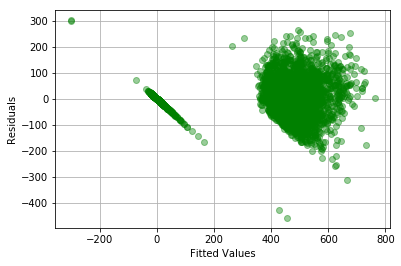

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.plot(y_test_predicted_list, residuals, color = 'green', marker = 'o', ls = '', alpha = 0.4)
plt.grid(linestyle = '-')
plt.ylabel('Residuals')
plt.xlabel('Fitted Values')

The residual plot above allows us to identify outliers in the dataset (An example is the point with residual=300).
It's possible to notify another interesting thing. There is a pattern close to the origin of the graph. As the fitted value increases, the residual is increased proportionally; a linear relationship. One possi